In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import splitfolders
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import matplotlib.image as mpimg
import os

2023-01-06 16:21:34.801036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 16:21:35.125398: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-06 16:21:35.129618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 16:21:35.129658: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

fonction pour separer les images en entrainement , test et validation

In [ ]:

splitfolders.ratio("DATA/data",output="DATA/brut",seed=1337, ratio=(.8, .1, .1 ), group_prefix=None, move=False) 

fonction pour charger des images

In [3]:
def load_images(folder):
    images = []
    imageslabel=[]
    for filename1 in os.listdir("DATA/"+folder):
        for filename in os.listdir("DATA/"+folder+"/"+filename1):
            img = mpimg.imread(os.path.join("DATA/"+folder+"/"+filename1, filename))
            if img.shape !=(28,28):
                img=img[:,:,0]
            if img is not None:
                images.append(img)
                imageslabel.append(filename1)
    return np.asarray(images),pd.DataFrame(imageslabel)

Creation de plusieur models avec plusieur paramettres.
Ces derniers qui varient ici sont:
1 o,2 ou 3 couche de convolution;
les fonction d'activations
la valeur d'une des couche  de dense .

Les models resultat de la fonction sont toute les combinaisons possibles de ces parametres.

In [4]:
def testConvcouche(nbf1,nbf2,nbf3,taillekernal):
    activations = ['linear', 'relu', 'tanh', 'elu', 'selu']
    model = []
    param=[]
    
    for k in range(8):
        for i in range (len(activations)):
            activation=activations[i]
            for j in range(3):
                m = Sequential()
                m.add(Conv2D(nbf1,kernel_size=taillekernal,padding='same',activation=activation,
                        input_shape=(28,28,1)))
                m.add(MaxPool2D())
                if j>0:
                    m.add(Conv2D(nbf2,kernel_size=taillekernal,padding='same',activation=activation))
                    m.add(MaxPool2D())
                if j>1:
                    m.add(Conv2D(nbf3,kernel_size=taillekernal,padding='same',activation=activation))
                    m.add(MaxPool2D(padding='same'))
                m.add(Flatten())
                if k>0:
                    m.add(Dense(2**(k+4), activation=activation))
                
                m.add(Dropout(0.5))
                m.add(Dense(10, activation='softmax'))
                m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
                model.append(m)
                param.append("model_nbconv="+str(j)+"_act="+str(activation)+"_kernal zize="+str(taillekernal)+"dense:="+str(2**(k+4))+"_filt1_2_3="+str(nbf1)+"_"+str(nbf2)+"_"+str(nbf3))
    return model ,param

chargement des images

In [34]:
folder="brut"
num_classes = 10
input_shape = (28, 28, 1)
x_train, y_train=load_images(folder+"/train")
x_val, y_val=load_images(folder+"/val")
x_test, y_test=load_images(folder+"/test")

y_test=y_test[0]
y_train=y_train[0]
y_val=y_val[0]

y_test=np.asarray(y_test.apply(lambda x : ord(x)-ord('A')))
y_train=np.asarray(y_train.apply(lambda x : ord(x)-ord('A')))
y_val=np.asarray(y_val.apply(lambda x : ord(x)-ord('A')))


x_train = x_train.astype("float32")
x_test = x_test.astype("float32") 
x_val = x_val.astype("float32")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(x_val.shape[0], "val samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


x_train shape: (14974, 28, 28, 1)
14974 train samples
1880 test samples
1870 val samples


In [6]:
img_width, img_height = 28, 28
top_model_weights_path = 'poidsNotMnist_A2jdata'+folder+'.h5'
train_data_dir = "DATA/"+folder+'/train/'
validation_data_dir ="/DATA/"+folder+'/val/'
test_data_dir="DATA/"+folder+'/test/'
nb_train_samples = x_train.shape[0],
nb_validation_samples = x_val.shape[0]
nb_test_samples=x_test.shape[0]

Fonction pour tester tout les models et enregistere les resultats dans de chacune dans un ficier csv 

In [15]:
def execute(folder,epochs,batch_size,nbf1,nbf2,nbf3,taillekernal):
    model,param=testConvcouche(nbf1,nbf2,nbf3,taillekernal)
    resultatfit=[]
    scoretest=[]
    print("nombre totale de model a tester pour epoch="+str(epochs)+" et de bash size="+str(batch_size) +" "+str(len(model)))
    for i in range (len(model) ):
        print(param[i])
        result=model[i].fit(x_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_val, y_val))
        score = model[i].evaluate(x_test,y_test, verbose=0)
        resultatfit.append(result)
        scoretest.append(score)
    for i in range (len(model)):
        scorede=pd.DataFrame(scoretest[i])
        scorede.to_csv("resultat/"+param[i]+"_e="+str(epochs)+"_b="+str(batch_size)+"test.csv", index=False)
        history_df = pd.DataFrame(resultatfit[i].history)
        history_df.to_csv("resultat/"+param[i]+"_e="+str(epochs)+"_b="+str(batch_size)+"entrainement.csv", index=False)
        #model[i].save(param[i]+"_e="+str(epochs)+"_b="+str(batch_size)+'model.h5')

lancement des entrainement avec de toute les models avec 20 epoch et bash 16 puis 32 puit 64 

In [16]:

execute("brut",20,16,24,48,64,5)
execute("brut",20,32,24,48,64,5)
execute("brut",20,64,24,48,64,5)


nombre totale de model a tester pour epoch=20 et de bash size=16 120
model_nbconv=0_act=linear_kernal zize=5dense:=16_filt1_2_3=24_48_64
Epoch 1/20
184/936 [====>.........................] - ETA: 2s - loss: 0.7323 - accuracy: 0.7897

KeyboardInterrupt: 

Recherche du model avec les meilleur resulatat 

fonction pour generer les non des fichier contenant les resultats

In [17]:
def testConvcouche(epochs,batch_size,nbf1,nbf2,nbf3,taillekernal):
    activations = ['linear', 'relu', 'tanh', 'elu', 'selu' ]
    paramtest=[]
    paramtestentrainement=[]
    for k in range(8):
        for i in range (len(activations)):
            activation=activations[i]
            for j in range(3):
                paramtest.append("resultat/"+"model_nbconv="+str(j)+"_act="+str(activation)+"_kernal zize="+str(taillekernal)+"dense:="+str(2**(k+4))+"_filt1_2_3="+str(nbf1)+"_"+str(nbf2)+"_"+str(nbf3)+"_e="+str(epochs)+"_b="+str(batch_size)+"test.csv")
                paramtestentrainement.append("resultat/"+"model_nbconv="+str(j)+"_act="+str(activation)+"_kernal zize="+str(taillekernal)+"dense:="+str(2**(k+4))+"_filt1_2_3="+str(nbf1)+"_"+str(nbf2)+"_"+str(nbf3)+"_e="+str(epochs)+"_b="+str(batch_size)+"entrainement.csv")
    return paramtest,paramtestentrainement

fonction pour determiner le model qui a les meilleur resultats

In [18]:
def best(bash):
    filesnamestest,filesnamesentrainement=testConvcouche(20,bash,24,48,64,5)
    data=[]
    datatest=[]
    for i in range(len(filesnamestest)):
        df = pd.read_csv(filesnamesentrainement[i], sep=',')
        dft = pd.read_csv(filesnamestest[i] )
        chiffres = range(0,20)
        chiffres = list(chiffres)
        df['epoch'] = chiffres
        data.append(df)
        datatest.append(dft.iloc[1,0])

    indexmax= datatest.index(max(datatest))
    print("model avec les meilleurs resultats: "+filesnamesentrainement[indexmax]) 
    print("accuracy test: "+ str(datatest[indexmax]))
    print("figure de l'apprentissage")
    fig, ax = plt.subplots()
    data[indexmax].plot(kind='scatter',x='epoch', y='accuracy', ax=ax)
    ax.set_xticks(range(0, 20, 1))
    plt.show()



test avec bach 16

model avec les meilleurs resultats: resultat/model_nbconv=1_act=relu_kernal zize=5dense:=256_filt1_2_3=24_48_64_e=20_b=16entrainement.csv
accuracy test: 0.9505318999290466
figure de l'apprentissage


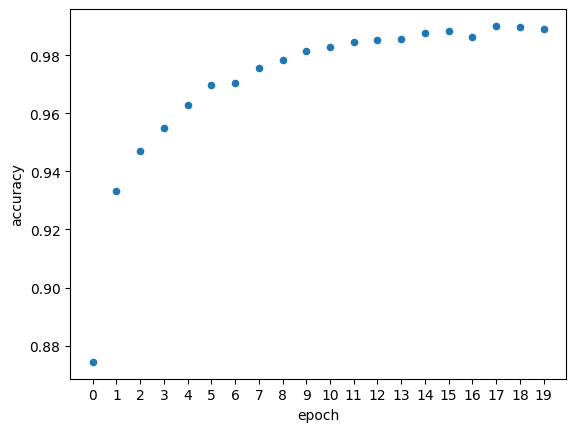

In [19]:
best(16)

test avec bash =32

model avec les meilleurs resultats: model_nbconv=2_act=relu_kernal zize=5dense:=16_filt1_2_3=24_48_64_e=20_b=32entrainement.csv
accuracy test: 0.9542553424835204
figure de l'apprentissage


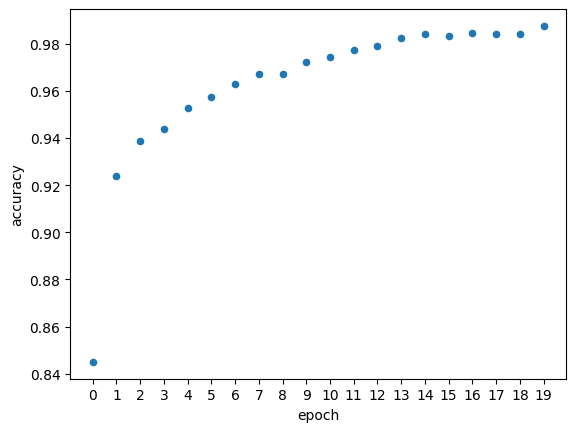

In [19]:
best(32)

best for bash =64

model avec les meilleurs resultats: resultat/model_nbconv=2_act=relu_kernal zize=5dense:=256_filt1_2_3=24_48_64_e=20_b=64entrainement.csv
accuracy test: 0.9521276354789734
figure de l'apprentissage


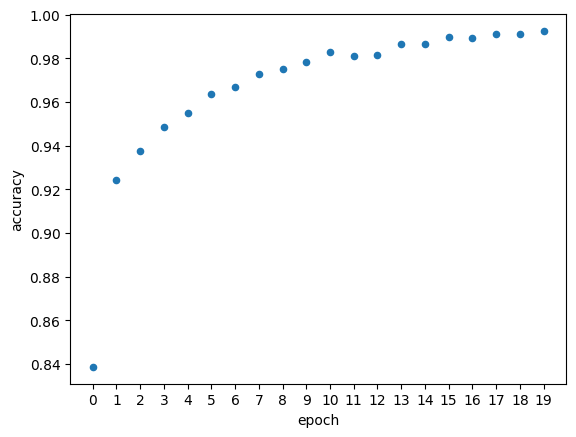

In [20]:
best(64)

celui qui donne le meilleur resultat est 


model_nbconv=2_act=relu_kernal zize=5dense:=16_filt1_2_3=24_48_64_e=20_b=32model.h5


entrainer avec un bash de 32 

In [21]:
model = keras.models.load_model('model_nbconv=2_act=relu_kernal zize=5dense:=16_filt1_2_3=24_48_64_e=20_b=32model.h5')

In [22]:
model.summary()

Model: "sequential_269"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_537 (Conv2D)         (None, 28, 28, 24)        624       
                                                                 
 max_pooling2d_537 (MaxPooli  (None, 14, 14, 24)       0         
 ng2D)                                                           
                                                                 
 conv2d_538 (Conv2D)         (None, 14, 14, 48)        28848     
                                                                 
 max_pooling2d_538 (MaxPooli  (None, 7, 7, 48)         0         
 ng2D)                                                           
                                                                 
 conv2d_539 (Conv2D)         (None, 7, 7, 64)          76864     
                                                                 
 max_pooling2d_539 (MaxPooli  (None, 4, 4, 64)      

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.23253268003463745
Test accuracy: 0.9542553424835205


augmentation des données avec un gan

In [24]:
Datafolder=["A","B","C","D","E","F","G","H","I","J"]
generateurs=[]
for j in range(10):     
 g=keras.models.load_model("gan/generateur"+Datafolder[j]+".h5")
 generateurs.append(g)

generer nb image par lettre

In [25]:
def generer(nb,name):
    for j in range(10):
         for i in range(nb):
            noise = tf.random.normal(shape=[1, 100])
            generated_images = generateurs[j](noise,1)
            images = np.squeeze(generated_images, axis=-1)
            for index, image in enumerate(images):
                plt.imsave(name+Datafolder[j]+"/"+str(i)+".png",image, cmap="binary")

In [34]:
generer(1000,"DATA/augmenter/")

splite des données 

In [35]:

splitfolders.ratio("DATA/augmenter",output="DATA/test",seed=1337, ratio=(.8, .1, .1 ), group_prefix=None, move=False) 

Copying files: 28724 files [00:02, 13571.33 files/s]


chargement des nouvellles donné

In [30]:
folder="test"
num_classes = 10
input_shape = (28, 28, 1)
x_train, y_train=load_images(folder+"/train")
x_val, y_val=load_images(folder+"/val")
x_test, y_test=load_images(folder+"/test")

y_test=y_test[0]
y_train=y_train[0]
y_val=y_val[0]

y_test=np.asarray(y_test.apply(lambda x : ord(x)-ord('A')))
y_train=np.asarray(y_train.apply(lambda x : ord(x)-ord('A')))
y_val=np.asarray(y_val.apply(lambda x : ord(x)-ord('A')))


x_train = x_train.astype("float32")
x_test = x_test.astype("float32") 
x_val = x_val.astype("float32")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(x_val.shape[0], "val samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)



x_train shape: (35518, 28, 28, 1)
35518 train samples
6476 test samples
6416 val samples


le model qui marche le mieux

In [31]:
def entrainement(epochs,batch_size):
        m = Sequential()
        m.add(Conv2D(24,kernel_size=5,padding='same',activation="relu" ,input_shape=(28,28,1)))
        m.add(MaxPool2D())
        m.add(Conv2D(48,kernel_size=5,padding='same',activation="relu" ))
        m.add(MaxPool2D())
        m.add(Conv2D(64,kernel_size=5,padding='same',activation="relu"))
        m.add(MaxPool2D(padding='same'))
        m.add(Flatten())

        m.add(Dropout(0.5))
        m.add(Dense(10, activation='softmax'))
        m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        m.summary()
        m.fit(x_train, y_train,
                epochs=epochs,  
                batch_size=batch_size,
                validation_data=(x_val, y_val))
        return m


entrainement du model

In [32]:

m = entrainement(20,32)

Model: "sequential_637"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1275 (Conv2D)        (None, 28, 28, 24)        624       
                                                                 
 max_pooling2d_1275 (MaxPool  (None, 14, 14, 24)       0         
 ing2D)                                                          
                                                                 
 conv2d_1276 (Conv2D)        (None, 14, 14, 48)        28848     
                                                                 
 max_pooling2d_1276 (MaxPool  (None, 7, 7, 48)         0         
 ing2D)                                                          
                                                                 
 conv2d_1277 (Conv2D)        (None, 7, 7, 64)          76864     
                                                                 
 max_pooling2d_1277 (MaxPool  (None, 4, 4, 64)      

In [35]:
score = m.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03757686913013458
Test accuracy: 0.9893617033958435


On aubserve une amelioration de l'accuracy du model